Auto Regressive `AR` Models fails to adjust quickly for unexpected shocks which can be mitigated by `MA`.  
Moving Average `MA` Models needs a baseline that can be provided by `AR`. 

So, Using `AR` and `MA` Terms together can complement each other and address the drawbacks.

Ideas of `AR` and `MA` in some detail in the below documents

[AR Model](https://github.com/arwin47/projects/blob/c9be8cf68b7dd95f7122f3bc31add7220aeb80be/Time%20Series%20-%20Auto%20Regressive%20Model.ipynb)  
[MA Model](https://github.com/arwin47/projects/blob/c9be8cf68b7dd95f7122f3bc31add7220aeb80be/Time%20Series%20-%20Moving%20Average%20Model.ipynb)

The ARMA model will have both past values terms(from AR) and past error terms(from MA). So it will have both AR order and MA order and these values can be varied independent of each other.

Current value = [Past value * Numeric Factor] + [Past error * Numeric Factor] + Constant + current residual.

IF p is the order of AR and q is the order of MA, the representation can be ARMA(p,q). If the model has 1 past value and 2 past error terms, it can be represented as ARMA(1,2)

Importing and preparing the time series data for modelling.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
df = pd.read_csv("Index2018.csv")
df['date'] = pd.to_datetime(df['date'], format="%d/%m/%Y")
df.set_index('date',inplace=True)
df = df.asfreq('b')

for col in df.columns.to_list():
    df[col] = df[col].fillna(method='ffill')
    df[col] = df[col].fillna(method='bfill')

df.isna().sum(axis=0) 

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

In [2]:
df.head(5)

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


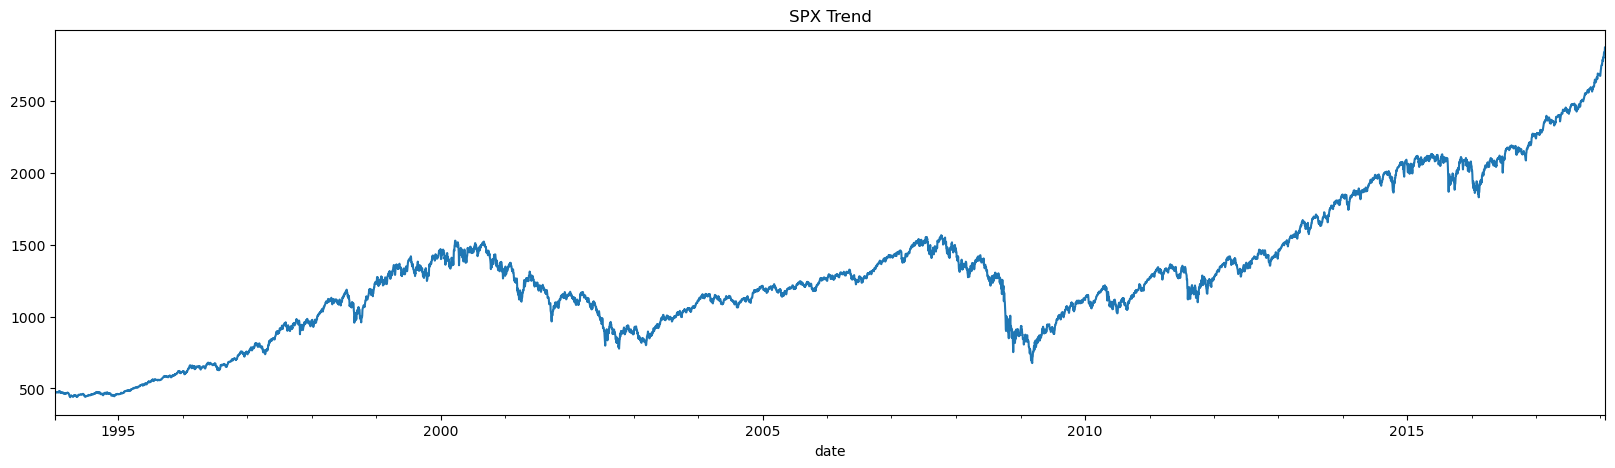

In [3]:
import matplotlib.pyplot as plt

df['spx'].plot(figsize=(20,5))
plt.title("SPX Trend")
plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller

if adfuller(df['spx'])[1]<0.05:
    print("Stationary")
else:
    print("Non-Stationary")

Non-Stationary


As the series is `non-stationary`, the `AR Model` will `not perform` well. The series needs to be transformed into `stationary` series before fitting the model. Using `percentage change` is a way to attain stationarity.

In [7]:
df['returns'] = df['spx'].pct_change(1).mul(100)
df = df.iloc[1:]   # removing the NA resulting from percent change calculation
df.head(3)

,spx,dax,ftse,nikkei,returns
date,,,,,
1994-01-11,474.13,2228.10,3413.77,18485.25,-0.239864
1994-01-12,474.17,2182.06,3372.02,18793.88,0.008437
1994-01-13,472.47,2142.37,3360.01,18577.26,-0.358521


In [25]:
if adfuller(df['returns'])[1]<0.05:
    print("Stationary")
else:
    print("Non-Stationary")

Stationary


As stationarity is achieved, let us proceed with model selection after splitting data into train and test groups.

In [11]:
test_size = int(len(df)*0.8)

df_train = df.iloc[:test_size]
df_test = df.iloc[test_size:]

Check for possible overlaps

In [12]:
df_train.tail(3)

,spx,dax,ftse,nikkei,returns
date,,,,,
2013-04-04,1559.979316,7817.39,6344.11,12634.54,0.404994
2013-04-05,1553.278930,7658.75,6249.77,12833.64,-0.429518
2013-04-08,1563.071269,7662.64,6276.94,13192.59,0.630430


In [13]:
df_test.head(3)

,spx,dax,ftse,nikkei,returns
date,,,,,
2013-04-09,1568.607909,7637.51,6313.20,13192.35,0.354215
2013-04-10,1587.731827,7810.63,6387.37,13288.13,1.219165
2013-04-11,1593.369863,7871.63,6416.14,13549.16,0.355100


Let us examine the lagged orders using `ACF` and `PACF`

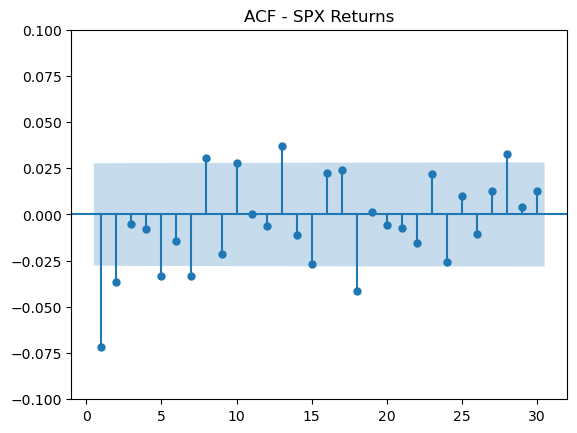

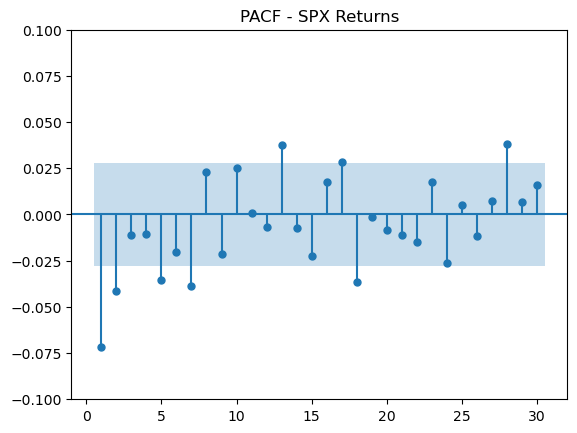

In [16]:
import statsmodels.graphics.tsaplots as sgt

sgt.plot_acf(df_train['returns'],lags = 30, zero=False ,title= 'ACF - SPX Returns') # zero=False avoids plotting the zeroth lag
plt.ylim(-0.1,0.1)
plt.show()

sgt.plot_pacf(df_train['returns'],lags = 30, zero=False,method=('ols'),title= 'PACF - SPX Returns') # zero=False avoids plotting the zeroth lag
plt.ylim(-0.1,0.1)
plt.show()

`ACF` shows 8 lags (ignoring 13 and 18 as they are far in the past) so the `MA` order can be upto 8.   
`PACF` shows 7 lags (ignoring 13 and 18 as they are far in the past) so the `AR` order can be upto 7.   

As `AR` and `MA` components can complement each other when used together, the best orders for combined `ARMA` could be lower than their individual orders. So, we can start with higher orders and iterate through the simpler ones through model comparison.


In [21]:
max_q = 8 # max order of MA 
max_p = 7 # max order of AR

min_q = 1 # max order of MA 
min_p = 1 # max order of AR

With specific series that is distributed around 0, we would worry much about insignificant coefficlent for `const`. As we are looking at `returns` which is bound to be distributed around zero for any efficient market, we will ignore the signifiance of `const` coefficient in the below evaluation.

In [58]:
from statsmodels.tsa.arima.model import ARIMA

for p in range(min_p,max_p):
	for q in range(min_q,max_q):
		globals()['arma_'+str(p)+'_'+str(q)] = ARIMA(df_train['returns'],order=(p,0,q))  
		globals()['arma_'+str(p)+'_'+str(q)+'_results'] = globals()['arma_'+str(p)+'_'+str(q)]\
            .fit(method_kwargs={ "maxiter": 500})
		print('arma_'+str(p)+'_'+str(q)+' model has',int((globals()['arma_'+str(p)+'_'+str(q)+'_results'].pvalues[1:-1] > 0.05)\
            .sum()),"(",round((int((globals()['arma_'+str(p)+'_'+str(q)+'_results'].pvalues[:-1] > 0.05)\
            .sum())/(i+1))*100,1),"% )", 'non-significant co-efficients and llf is',\
              round(globals()['arma_'+str(p)+'_'+str(q)+'_results'].llf,1))

arma_1_1 model has 0 ( 0.0 % ) non-significant co-efficients and llf is -8060.3
arma_1_2 model has 1 ( 4.8 % ) non-significant co-efficients and llf is -8059.8
arma_1_3 model has 2 ( 9.5 % ) non-significant co-efficients and llf is -8059.7
arma_1_4 model has 2 ( 9.5 % ) non-significant co-efficients and llf is -8058.9
arma_1_5 model has 3 ( 14.3 % ) non-significant co-efficients and llf is -8057.1
arma_1_6 model has 2 ( 9.5 % ) non-significant co-efficients and llf is -8056.7
arma_1_7 model has 1 ( 4.8 % ) non-significant co-efficients and llf is -8051.9
arma_2_1 model has 1 ( 4.8 % ) non-significant co-efficients and llf is -8059.9
arma_2_2 model has 4 ( 19.0 % ) non-significant co-efficients and llf is -8060.2
arma_2_3 model has 3 ( 14.3 % ) non-significant co-efficients and llf is -8059.5
arma_2_4 model has 4 ( 19.0 % ) non-significant co-efficients and llf is -8058.9
arma_2_5 model has 4 ( 19.0 % ) non-significant co-efficients and llf is -8055.3
arma_2_6 model has 5 ( 23.8 % ) non

Used `maxiter=500` because some higher order models didn't converge with default settings. If convergence is not achieved, we can use different defaults starting with the below. 

1. Set a different interation limit by using model.fit(method_kwargs={"maxiter": maxiter}).
2. Manually initializing the parameters Eg. For ARIMA(1,0,1), we can set some initial values to parameters using model.fit(start_params=[0.5, 0.3, -0.2, 1.0]) which specify initial guesses for [const, ar.L1, ma.L1, sigma2].
3. Set one of these solvers 'lbfgs', 'powell', 'bfgs' like model.fit(method_kwargs={"solver": "lbfgs"})

Creating a results dataframe for `model comparison`

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

for p in range(min_p,max_p):
	for q in range(min_q,max_q):
		globals()['arma_'+str(p)+'_'+str(q)] = ARIMA(df_train['returns'],order=(p,0,q))  
		globals()['arma_'+str(p)+'_'+str(q)+'_results'] = globals()['arma_'+str(p)+'_'+str(q)]\
            .fit(method_kwargs={ "maxiter": 500})
		print('arma_'+str(p)+'_'+str(q)+' model has',int((globals()['arma_'+str(p)+'_'+str(q)+'_results'].pvalues[1:-1] > 0.05)\
            .sum()),"(",round((int((globals()['arma_'+str(p)+'_'+str(q)+'_results'].pvalues[:-1] > 0.05)\
            .sum())/(i+1))*100,1),"% )", 'non-significant co-efficients and llf is',\
              round(globals()['arma_'+str(p)+'_'+str(q)+'_results'].llf,1))